In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.00204383 (max: 1e-06)
	Norm deltaX: 0.0206369, Norm R: 0.198075
	deltaX: 0 -0.0206369 
	deltaR: 0 -0.198075 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 1.932e-05 (max: 1e-06)
	Norm deltaX: 0.00198298, Norm R: 0.0194857
	deltaX: 0 -0.00198298 
	deltaR: 0 -0.0194857 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 1.81363e-07 (max: 1e-06)
	Norm deltaX: 0.000191916, Norm R: 0.00189002
	deltaX: 0 -0.000191916 
	deltaR: 0 -0.00189002 

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.000406793 (max: 1e-06)
	Norm deltaX: 0.00730069, Norm R: 0.11144
	deltaX: 0 -0.00730069 
	deltaR: 0 -0.11144 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 2.16121e-06 (max: 1e-06)
	Norm deltaX: 0.000531658, Norm R: 0.00813006
	deltaX: 0 -0.000531658 
	deltaR: 0 -0.00813006 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 1.10087e-08 (max: 1e-06)
	Norm deltaX: 3.79423e-05, Norm R: 0.000580

[[ 0.          0.        ]
 [ 0.38046416  5.09324431]
 [ 0.78465569  7.38555198]
 [ 1.19314982  8.55580605]
 [ 1.59790544 10.73471751]
 [ 1.98042149 15.65423309]
 [ 2.31398385 23.60101116]
 [ 2.59160916 33.65774944]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 [ 2.82341344 44.93046846]
 

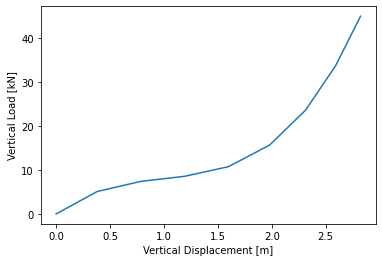

Running Time:  1.2935395240783691  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.41 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.6  #Initial value of lambda (arc length parameter)
spring_stiffness = 8.007


#Geometric and material properties
E1 = 800000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 800000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 20 #kN

#Coordinates of the nodes
Lhalf = 11.4
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=100 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 50, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = abs(ops.nodeDisp(2,2)) 
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')